In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model

from keras2.layers import concatenate, Dense, Input, Flatten, merge
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
    )
    return agent

def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

In [4]:
NN = branch_actor((2,),(2,))

In [5]:
# 学習データの用意
tau = 0.1
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0]), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.005
(30000, 1, 2) (30000, 2)


In [6]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=150, verbose=0)

In [7]:
# save
NN.save_weights('./saved_agent/self_trigger_split_01.h5')

In [8]:
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger_split_01.h5')

NN: 1.8558658361434937, opt: 1.8135041588679095
NN: -1.1976979970932007, opt: -1.139805676492492
NN: 1.5075653791427612, opt: 1.4714258794605686
NN: -1.2315477132797241, opt: -1.1718668972515751
NN: -0.11781499534845352, opt: -0.10133639072542135
NN: 0.5591801404953003, opt: 0.5462795942628899
NN: -3.056041717529297, opt: -3.0149518285680212
NN: 3.9139797687530518, opt: 3.977751546141092
NN: 4.8642425537109375, opt: 4.801099613967487
NN: 1.685746669769287, opt: 1.6469492742183336
NN: 0.28876084089279175, opt: 0.2900888289015494
NN: 1.7145545482635498, opt: 1.6728408754057278
NN: 0.9411402940750122, opt: 0.9207463242009718
NN: 2.3420073986053467, opt: 2.3060789871477714
NN: -0.33758842945098877, opt: -0.31450626941259924
NN: 3.6897895336151123, opt: 3.728062898938405
NN: -1.745766520500183, opt: -1.6811932167734034
NN: -2.918534755706787, opt: -2.870856676957328
NN: -4.439351558685303, opt: -4.570015967625515
NN: -1.4235754013061523, opt: -1.3613924580653096
NN: 1.2125427722930908, opt:

NN: 0.6514579653739929, opt: 0.6402867929107514
NN: -4.164988040924072, opt: -4.2484218738817034
NN: -1.3048111200332642, opt: -1.2428867031090074
NN: -2.30208683013916, opt: -2.238734053299341
NN: -2.5813534259796143, opt: -2.5187367652356323
NN: -0.8724569082260132, opt: -0.824138193786129
NN: 0.41965141892433167, opt: 0.41416429573053637
NN: -5.039635181427002, opt: -5.310322007317268
NN: 0.4081476330757141, opt: 0.40273832454347047
NN: 2.3082473278045654, opt: 2.2636556654316213
NN: 2.402280807495117, opt: 2.3624207523352307
NN: -3.7780470848083496, opt: -3.80200570826758
NN: -2.8531570434570312, opt: -2.8010614085688013
NN: 1.222562313079834, opt: 1.1908659714457883
NN: -2.563845634460449, opt: -2.5026530035074472
NN: -1.5310401916503906, opt: -1.46772606208278
NN: -2.6254706382751465, opt: -2.5661651303504787
NN: 0.8805042505264282, opt: 0.8620791269888682
NN: 3.514115571975708, opt: 3.5345645001875843
NN: 5.548635482788086, opt: 5.4606068307662925
NN: -0.44125431776046753, opt: 

NN: -0.7086057066917419, opt: -0.6639981032235589
NN: 1.7899200916290283, opt: 1.7481328524235806
NN: -1.876172423362732, opt: -1.804388925077189
NN: 3.0415148735046387, opt: 3.0316251535699723
NN: -5.754812240600586, opt: -6.278908474035197
NN: 0.30088984966278076, opt: 0.3026750074851927
NN: -1.0203396081924438, opt: -0.9726320348707083
NN: -1.315245509147644, opt: -1.2550585707666093
NN: 1.3616642951965332, opt: 1.3270717570316677
NN: 5.109739780426025, opt: 5.032249378426125
NN: -3.9477345943450928, opt: -3.9958821687971744
NN: 1.0013617277145386, opt: 0.9774029945195442
NN: -3.795149803161621, opt: -3.820400020619404
NN: -0.9380019903182983, opt: -0.8945466821215364
NN: 2.34731125831604, opt: 2.306921532105878
NN: -1.8552292585372925, opt: -1.7915018540123437
NN: -1.212809681892395, opt: -1.1553039822379039
NN: -0.039949752390384674, opt: -0.027984905595914156
NN: -1.8801496028900146, opt: -1.808489146353817
NN: -1.0179680585861206, opt: -0.9607575780729911
NN: -0.6385213136672974

NN: -3.4055137634277344, opt: -3.391258778696585
NN: 1.8743433952331543, opt: 1.8324841876345028
NN: 2.7260098457336426, opt: 2.6966785392636345
NN: 0.49659794569015503, opt: 0.48494371835005934
NN: -1.1523549556732178, opt: -1.0980292084579024
NN: 1.285667896270752, opt: 1.2571234045810527
NN: 1.8657959699630737, opt: 1.8260500186772173
NN: -1.7829090356826782, opt: -1.7182082625560477
NN: -0.585797131061554, opt: -0.5512981006176578
NN: -1.991762638092041, opt: -1.9211593493184058
NN: 2.4930474758148193, opt: 2.4522554147143873
NN: 2.3221185207366943, opt: 2.2824869765343605
NN: 0.8035216331481934, opt: 0.7829717650384844
NN: 1.2851622104644775, opt: 1.2502769894358585
NN: -1.892463207244873, opt: -1.827333420599718
NN: -4.714372158050537, opt: -4.897370577226653
NN: 0.873286247253418, opt: 0.853231701768094
NN: 5.162599086761475, opt: 5.082567949832828
NN: 2.874401569366455, opt: 2.8510427959071984
NN: 0.9168127179145813, opt: 0.8945421756313009
NN: 1.0015915632247925, opt: 0.975995

NN: 3.769249439239502, opt: 3.8144829359007426
NN: 0.6229532361030579, opt: 0.6159082957871427
NN: 0.06262701749801636, opt: 0.06645497485474783
NN: -1.8925845623016357, opt: -1.827614349428801
NN: 0.3636820912361145, opt: 0.3550628014564867
NN: 0.36883479356765747, opt: 0.36515899082144376
NN: -0.8114648461341858, opt: -0.7650391663309386
NN: 2.043884754180908, opt: 2.0001000958250494
NN: -2.283271312713623, opt: -2.218187816170303
NN: -1.7539594173431396, opt: -1.6892021190233493
NN: 0.2783149182796478, opt: 0.2775454440671384
NN: -2.1034798622131348, opt: -2.032349426348757
NN: 2.060788869857788, opt: 2.0169315369625562
NN: 4.025916576385498, opt: 4.093352730384999
NN: -0.09732604771852493, opt: -0.07976591180599349
NN: 5.268360137939453, opt: 5.1878090426863475
NN: -1.3983705043792725, opt: -1.3447229647090495
NN: 4.207587718963623, opt: 4.239311010929304
NN: 0.7252801060676575, opt: 0.706677333179954
NN: -3.0219016075134277, opt: -2.9762835679614392
NN: 0.6698388457298279, opt: 0.

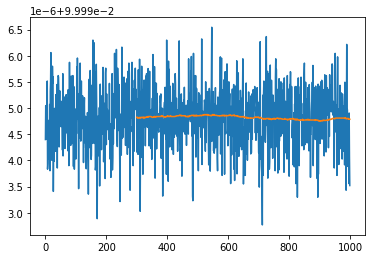

In [9]:
# validation
taus = []
for i in range(1000):
    x = np.random.randn(2,) / 16.
    a_agent, tau = a.forward(x)
    taus.append(tau)
    print(f'NN: {a_agent}, opt: {np.dot(K, x)}')
plt.plot(range(len(taus)), taus)
plt.plot(range(300, len(taus)), moving_average(taus, 300))
plt.show()

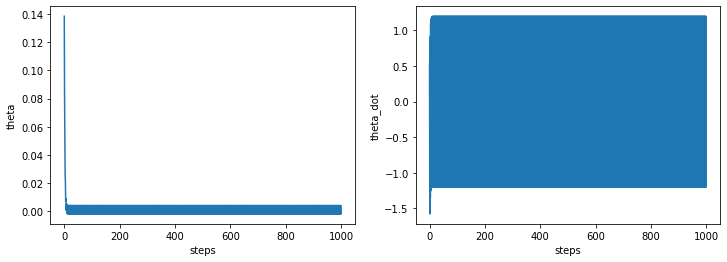

In [10]:
# 実環境テスト

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2*np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
for i in range(1000):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [12]:
print(taus)

[0.0999944, 0.09999505, 0.099994406, 0.09999501, 0.09999491, 0.09999487, 0.099995516, 0.09999383, 0.09999394, 0.09999435, 0.099994764, 0.099994466, 0.0999945, 0.099994026, 0.09999507, 0.0999938, 0.09999533, 0.099995516, 0.09999606, 0.099995136, 0.09999443, 0.099994004, 0.099995114, 0.0999958, 0.09999548, 0.0999956, 0.09999341, 0.09999426, 0.09999398, 0.09999455, 0.099994995, 0.099994935, 0.09999489, 0.099994175, 0.099995255, 0.099994525, 0.09999509, 0.09999428, 0.09999545, 0.099993855, 0.09999503, 0.09999541, 0.09999562, 0.09999559, 0.09999528, 0.09999426, 0.09999507, 0.09999533, 0.09999488, 0.099994846, 0.09999475, 0.099994645, 0.09999513, 0.09999481, 0.09999485, 0.09999471, 0.0999942, 0.09999566, 0.099994086, 0.099994905, 0.09999461, 0.09999467, 0.099994525, 0.09999521, 0.09999423, 0.09999462, 0.09999468, 0.09999482, 0.099995255, 0.09999515, 0.099994525, 0.099995166, 0.0999946, 0.09999444, 0.09999418, 0.09999535, 0.09999461, 0.0999939, 0.09999451, 0.099995874, 0.09999432, 0.09999434,